In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import librosa
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Input, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras_self_attention import SeqSelfAttention 
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import pickle
from keras.models import load_model

In [29]:
import warnings
warnings.filterwarnings('ignore')

In [84]:
model=load_model(r'..\Serialized_objects\RDM_Diagnose.h5',custom_objects={'SeqSelfAttention': SeqSelfAttention})
LabelEncoder = pickle.load(open(r'..\Serialized_objects\disease_encoder.pkl', 'rb'))

In [2]:
#function for extracting class labels
def extract_label(file,df):
    id=os.path.basename(file).split('_')[0]
    label=df[df['patient_id']==int(id)]['diagnosis'].values[0]
    return label


#function for extracting mfcc features
def feature_extraction(file,max_pad_len=926,n_features=52):
# Load the .wav file
    audio, sample_rate = librosa.load(file)
    # Extract the MFCC features
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate,n_mfcc=n_features)
    
    # If the array is shorter than max_pad_len, pad it with zeros
    if (mfccs.shape[1] < max_pad_len):
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    
    # If the array is longer than max_pad_len, truncate it
    elif (mfccs.shape[1] > max_pad_len):
        mfccs = mfccs[:, :max_pad_len]
        
    return mfccs


In [23]:
audio_files=glob.glob(r'..\Respiratory_Sound_Database\audio_and_txt_files\*.wav')

In [24]:
audio_files[0:5]
#Respiratory_Sound_Database\audio_and_txt_files\101_1b1_Al_sc_Meditron_aug_3.wav
#E:\Lea!n\RDM\Respiratory_Sound_Database\audio_and_txt_files\101_1b1_Al_sc_Meditron_aug_1.wav

['..\\Respiratory_Sound_Database\\audio_and_txt_files\\101_1b1_Al_sc_Meditron.wav',
 '..\\Respiratory_Sound_Database\\audio_and_txt_files\\101_1b1_Al_sc_Meditron_aug_0.wav',
 '..\\Respiratory_Sound_Database\\audio_and_txt_files\\101_1b1_Al_sc_Meditron_aug_1.wav',
 '..\\Respiratory_Sound_Database\\audio_and_txt_files\\101_1b1_Al_sc_Meditron_aug_10.wav',
 '..\\Respiratory_Sound_Database\\audio_and_txt_files\\101_1b1_Al_sc_Meditron_aug_11.wav']

In [22]:
df=pd.read_csv(r'..\Respiratory_Sound_Database\patient_diagnosis.csv',names=['patient_id','diagnosis'])
df.head()

,patient_id,diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [42]:
mfccs_features=[]
length=[]
labels=[]
max_pad_len=926
for i in audio_files:
    mfccs=feature_extraction(i,max_pad_len,52)
    mfccs_features.append(mfccs)
    labels.append(extract_label(i,df))
    length.append(mfccs.shape[1])

In [45]:
np.array(labels).shape

(6524,)

In [46]:

labels=np.array(labels)
labels=LabelEncoder.transform(labels)
one_hot_labels=to_categorical(labels,num_classes=8)
one_hot_labels

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [50]:
X_train,X_test,y_train,y_test=train_test_split(mfccs_features,one_hot_labels,test_size=0.2,random_state=28)

In [52]:
np.array(X_test).shape

(1305, 52, 926)

In [53]:
predictions=model.predict(np.array(X_test))
predictions=np.argmax(predictions,axis=1)
y_test=np.argmax(y_test,axis=1)
class_labels=list(LabelEncoder.classes_)
cm=confusion_matrix(y_test,predictions)

41/41 [==============================] - 5s 46ms/step


In [54]:
cm

array([[167,   0,   0,   0,   0,   0,   0,   0],
       [  0, 148,   0,   0,   0,   0,   0,   0],
       [  0,   0, 166,   0,   0,   0,   0,   0],
       [  0,   1,   0, 171,   0,   0,   4,   0],
       [  0,   0,   0,   0, 170,   0,   1,   0],
       [  0,   0,   0,   0,   0, 147,   0,   0],
       [  0,   0,   0,   0,   0,   0, 162,   0],
       [  0,   0,   0,   0,   1,   0,   0, 167]], dtype=int64)

In [57]:
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
accuracy

0.9946360153256705

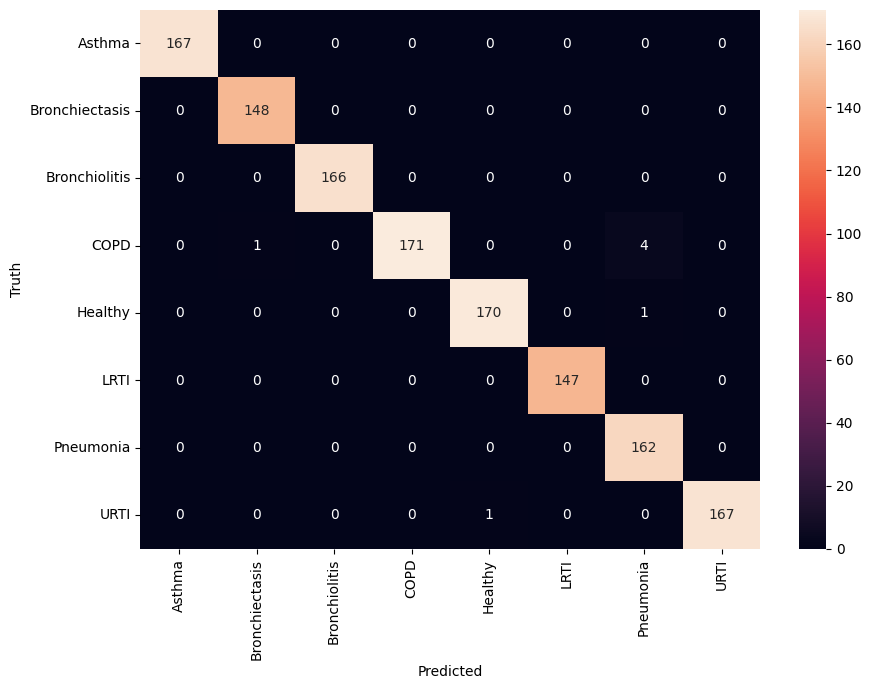

In [55]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [90]:
def predictor(file):
    mfcc=feature_extraction(file)
    mfcc=np.expand_dims(mfcc,axis=0)
    predict=model.predict(mfcc,verbose=0)
    label=LabelEncoder.inverse_transform(np.argmax(predict,axis=1))[0]
    return label

In [68]:
files=[r'..\Respiratory_Sound_Database\audio_and_txt_files\101_1b1_Al_sc_Meditron_aug_3.wav',
       r'..\Respiratory_Sound_Database\audio_and_txt_files\108_1b1_Al_sc_Meditron.wav',
       r'..\Respiratory_Sound_Database\audio_and_txt_files\111_1b2_Tc_sc_Meditron.wav',
       r'..\Respiratory_Sound_Database\audio_and_txt_files\122_2b2_Al_mc_LittC2SE.wav',
       r'..\Respiratory_Sound_Database\audio_and_txt_files\121_1b1_Tc_sc_Meditron.wav']

In [94]:
def tester(files, df):
    print(f'{"Actual Label":<20} {"Predicted Label"}')
    print('-' * 90)
    match_count = 0
    for file in files:
        label = extract_label(file, df)
        predicted_label = predictor(file)
        print(f'{label:<20} {predicted_label}')
        if label == predicted_label:
            match_count += 1
    print(f'\nTotal matches: {match_count} out of {len(files)}')


In [95]:
tester(files,df)

Actual Label         Predicted Label
------------------------------------------------------------------------------------------
URTI                 URTI
LRTI                 LRTI
Bronchiectasis       Bronchiectasis
Pneumonia            Pneumonia
Healthy              Healthy

Total matches: 5 out of 5
